In [1]:
import numpy as np

X_train = np.load("X_train_higgs.npy")
y_train = np.load("y_train_higgs.npy")
X_test  = np.load("X_test_higgs.npy")
y_test  = np.load("y_test_higgs.npy")


In [2]:
from sklearn.datasets import fetch_rcv1
from sklearn.model_selection import train_test_split


rcv1 = fetch_rcv1()
X = rcv1.data  
y = rcv1.target


target_names = rcv1.target_names.tolist()
ccat_idx = target_names.index('CCAT')
y_ccat = y[:, ccat_idx].toarray().astype(int)


indices = np.random.choice(X.shape[0], 10000, replace=False)
X_subset = X[indices]
y_subset = y_ccat[indices]


X_train_rcv1, X_test_rcv1, y_train_rcv1, y_test_rcv1 = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

print(f"RCV1 Yüklendi! Eğitim: {X_train_rcv1.shape}, Test: {X_test_rcv1.shape}")

RCV1 Yüklendi! Eğitim: (8000, 47236), Test: (2000, 47236)


In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z)**2

In [4]:
class MLP:
    def __init__(self, layer_sizes, activation="relu"):
        self.layer_sizes = layer_sizes
        self.activation_name = activation
        self.weights = []
        self.biases = []

        # 1. Ağırlıkları baslatma 
        self._init_parameters()

        # 2. Optimizer Hafıza Birimleri
        # Momentum
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.v_b = [np.zeros_like(b) for b in self.biases]

        # RMSProp
        self.s_w = [np.zeros_like(w) for w in self.weights]
        self.s_b = [np.zeros_like(b) for b in self.biases]

        # Adam
        self.t = 0
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_w2 = [np.zeros_like(w) for w in self.weights]
        self.v_b2 = [np.zeros_like(b) for b in self.biases]
   
    def _init_parameters(self):
        for i in range(len(self.layer_sizes) - 1):
            n_in = self.layer_sizes[i]
            # He Initialization , Xavier 
            std = np.sqrt(2.0 / n_in) if self.activation_name == "relu" else np.sqrt(1.0 / n_in)
            
            w = np.random.randn(n_in, self.layer_sizes[i + 1]) * std
            b = np.zeros((1, self.layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def _activation(self, z):
        if self.activation_name == "relu": return np.maximum(0, z)
        elif self.activation_name == "sigmoid": return 1 / (1 + np.exp(-z))
        elif self.activation_name == "tanh": return np.tanh(z)
        return z

    def _activation_derivative(self, z):
        if self.activation_name == "relu": return (z > 0).astype(float)
        elif self.activation_name == "sigmoid":
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif self.activation_name == "tanh": return 1 - np.tanh(z)**2
        return 1

    def forward(self, X):
        self.cache = []
        a = X
        for i in range(len(self.weights)):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = 1 / (1 + np.exp(-z)) if i == len(self.weights) - 1 else self._activation(z)
            self.cache.append((a, z))
        return a

    def backward(self, X, y_true, y_pred, lr=0.01, optimizer="sgd", beta1=0.9, beta2=0.999, eps=1e-8):
        m = X.shape[0]
        dz = y_pred - y_true 
        if optimizer == "adam": self.t += 1

        for i in reversed(range(len(self.weights))):
            a_prev = X if i == 0 else self.cache[i-1][0]
            dw = (1 / m) * np.dot(a_prev.T, dz)
            db = (1 / m) * np.sum(dz, axis=0, keepdims=True)

        
            if i > 0:
                z_prev = self.cache[i-1][1]
                dz_next = np.dot(dz, self.weights[i].T) * self._activation_derivative(z_prev)

        
            if optimizer == "momentum":
                self.v_w[i] = beta1 * self.v_w[i] + (1 - beta1) * dw
                self.v_b[i] = beta1 * self.v_b[i] + (1 - beta1) * db
                self.weights[i] -= lr * self.v_w[i]
                self.biases[i] -= lr * self.v_b[i]
            elif optimizer == "rmsprop":
                self.s_w[i] = beta1 * self.s_w[i] + (1 - beta1) * (dw**2)
                self.s_b[i] = beta1 * self.s_b[i] + (1 - beta1) * (db**2)
                self.weights[i] -= lr * dw / (np.sqrt(self.s_w[i]) + eps)
                self.biases[i] -= lr * db / (np.sqrt(self.s_b[i]) + eps)
            elif optimizer == "adam":
                self.m_w[i] = beta1 * self.m_w[i] + (1 - beta1) * dw
                self.m_b[i] = beta1 * self.m_b[i] + (1 - beta1) * db
                self.v_w2[i] = beta2 * self.v_w2[i] + (1 - beta2) * (dw**2)
                self.v_b2[i] = beta2 * self.v_b2[i] + (1 - beta2) * (db**2)
                mw_h = self.m_w[i] / (1 - beta1**self.t)
                mb_h = self.m_b[i] / (1 - beta1**self.t)
                vw_h = self.v_w2[i] / (1 - beta2**self.t)
                vb_h = self.v_b2[i] / (1 - beta2**self.t)
                self.weights[i] -= lr * mw_h / (np.sqrt(vw_h) + eps)
                self.biases[i] -= lr * mb_h / (np.sqrt(vb_h) + eps)
            else: # SGD
                self.weights[i] -= lr * dw
                self.biases[i] -= lr * db

            if i > 0: dz = dz_next

        

In [5]:
mlp = MLP([28, 64, 32, 1], activation="relu")
y_pred = mlp.forward(X_train[:10])
print(y_pred.shape)

(10, 1)


In [6]:
mlp = MLP([28, 64, 32, 16, 1], activation="relu")
y_pred = mlp.forward(X_train[:10])
print(y_pred.shape)

(10, 1)


In [7]:
def forward(self, X):
    
        self.cache = []
        a = X

        for i in range(len(self.weights)):
            z = np.dot(a, self.weights[i]) + self.biases[i]

            # output layer
            if i == len(self.weights) - 1:
                a = sigmoid(z)   # binary classification output
            else:
                a = self._activation(z)

            self.cache.append((a, z))

        return a

In [8]:
def binary_cross_entropy(y_true, y_pred, eps=1e-8):

    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

In [9]:
y_pred_test = mlp.forward(X_train[:10])
loss_test = binary_cross_entropy(y_train[:10], y_pred_test)

print("Loss:", loss_test)

Loss: 0.8090633354883152


In [10]:
def binary_cross_entropy_derivative(y_true, y_pred):
    
    return y_pred - y_true

In [11]:
def train_mlp(model, X, y, epochs=5, batch_size=16, lr=0.01, optimizer="sgd"):
    n_samples = X.shape[0]
    losses = []

    for epoch in range(epochs):
        # ÖNEMLİ: Tüm matrisi karıştırmak yerine sadece indeksleri karıştırıyoruz
        perm = np.random.permutation(n_samples)
        epoch_loss = 0.0

        for i in range(0, n_samples, batch_size):
            # Sadece o anki küçük grubun indekslerini al
            indices = perm[i:i + batch_size]
            
            # Veriyi sadece burada ve sadece 16 satırlık parça halinde yoğunlaştır (dense yap)
            X_batch = X[indices]
            if hasattr(X_batch, "toarray"): # RCV1 gibi sparse veriler için
                X_batch = X_batch.toarray().astype(np.float32)
            else:
                X_batch = X_batch.astype(np.float32)
                
            y_batch = y[indices]

            # Forward (İleri Yayılım)
            y_pred = model.forward(X_batch)

            # Loss (Kayıp Hesaplama)
            loss = binary_cross_entropy(y_batch, y_pred)
            epoch_loss += loss

            # Backward (Geri Yayılım)
            model.backward(X_batch, y_batch, y_pred, lr=lr, optimizer=optimizer)

        avg_loss = epoch_loss / (n_samples // batch_size)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return losses
      
    

In [12]:
# 1. RCV1 için giriş katman boyutunu tanımla (47236)
input_dim_rcv1 = X_train_rcv1.shape[1] 
layer_sizes_rcv1 = [input_dim_rcv1, 16, 8, 1]

# 2. RCV1 için Optimizer Karşılaştırması
# Not: Eğitim süresi uzun sürebilir, epoch sayısını test için 10 tutabilirsin.

# RCV1 - SGD
mlp_rcv1_sgd = MLP(layer_sizes_rcv1, activation="relu")
loss_rcv1_sgd = train_mlp(mlp_rcv1_sgd, X_train_rcv1, y_train_rcv1, epochs=5, optimizer="sgd")

# RCV1 - Momentum
mlp_rcv1_momentum = MLP(layer_sizes_rcv1, activation="relu")
loss_rcv1_momentum = train_mlp(mlp_rcv1_momentum, X_train_rcv1, y_train_rcv1, epochs=5, optimizer="momentum")

# RCV1 - RMSProp
mlp_rcv1_rmsprop = MLP(layer_sizes_rcv1, activation="relu")
loss_rcv1_rmsprop = train_mlp(mlp_rcv1_rmsprop, X_train_rcv1, y_train_rcv1, epochs=5, optimizer="rmsprop")

# RCV1 - Adam
mlp_rcv1_adam = MLP(layer_sizes_rcv1, activation="relu")
loss_rcv1_adam = train_mlp(mlp_rcv1_adam, X_train_rcv1, y_train_rcv1, epochs=5, optimizer="adam")


Epoch 1/5 - Loss: 0.6912
Epoch 2/5 - Loss: 0.6826
Epoch 3/5 - Loss: 0.6684
Epoch 4/5 - Loss: 0.6479
Epoch 5/5 - Loss: 0.6182
Epoch 1/5 - Loss: 0.6882
Epoch 2/5 - Loss: 0.6745
Epoch 3/5 - Loss: 0.6564
Epoch 4/5 - Loss: 0.6287
Epoch 5/5 - Loss: 0.5852
Epoch 1/5 - Loss: 0.2451
Epoch 2/5 - Loss: 0.1216
Epoch 3/5 - Loss: 0.0856
Epoch 4/5 - Loss: 0.0647
Epoch 5/5 - Loss: 0.0471
Epoch 1/5 - Loss: 0.2577
Epoch 2/5 - Loss: 0.0480
Epoch 3/5 - Loss: 0.0155
Epoch 4/5 - Loss: 0.0081
Epoch 5/5 - Loss: 0.0053


In [13]:
epochs = 30
lr = 0.01
batch_size = 64

layer_sizes = [28, 64, 32, 1]

# 1. Standart Mini-batch SGD
mlp_sgd = MLP(layer_sizes, activation="relu")
loss_sgd = train_mlp(
    model=mlp_sgd,
    X=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    optimizer="sgd"
)

# 2. SGD with Momentum
mlp_momentum = MLP(layer_sizes, activation="relu")
loss_momentum = train_mlp(
    model=mlp_momentum,
    X=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    optimizer="momentum"
)

# 3. RMSProp
mlp_rmsprop = MLP(layer_sizes, activation="relu")
loss_rmsprop = train_mlp(
    model=mlp_rmsprop,
    X=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    optimizer="rmsprop"
)

# 4. Adam
mlp_adam = MLP(layer_sizes, activation="relu")
loss_adam = train_mlp(
    model=mlp_adam,
    X=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    optimizer="adam"
)



Epoch 1/30 - Loss: 0.7492
Epoch 2/30 - Loss: 0.6840
Epoch 3/30 - Loss: 0.6690
Epoch 4/30 - Loss: 0.6615
Epoch 5/30 - Loss: 0.6565
Epoch 6/30 - Loss: 0.6528
Epoch 7/30 - Loss: 0.6496
Epoch 8/30 - Loss: 0.6469
Epoch 9/30 - Loss: 0.6448
Epoch 10/30 - Loss: 0.6425
Epoch 11/30 - Loss: 0.6406
Epoch 12/30 - Loss: 0.6389
Epoch 13/30 - Loss: 0.6369
Epoch 14/30 - Loss: 0.6354
Epoch 15/30 - Loss: 0.6339
Epoch 16/30 - Loss: 0.6326
Epoch 17/30 - Loss: 0.6312
Epoch 18/30 - Loss: 0.6300
Epoch 19/30 - Loss: 0.6287
Epoch 20/30 - Loss: 0.6276
Epoch 21/30 - Loss: 0.6263
Epoch 22/30 - Loss: 0.6251
Epoch 23/30 - Loss: 0.6240
Epoch 24/30 - Loss: 0.6230
Epoch 25/30 - Loss: 0.6219
Epoch 26/30 - Loss: 0.6210
Epoch 27/30 - Loss: 0.6199
Epoch 28/30 - Loss: 0.6189
Epoch 29/30 - Loss: 0.6180
Epoch 30/30 - Loss: 0.6168
Epoch 1/30 - Loss: 0.7189
Epoch 2/30 - Loss: 0.6933
Epoch 3/30 - Loss: 0.6844
Epoch 4/30 - Loss: 0.6788
Epoch 5/30 - Loss: 0.6741
Epoch 6/30 - Loss: 0.6700
Epoch 7/30 - Loss: 0.6663
Epoch 8/30 - Loss

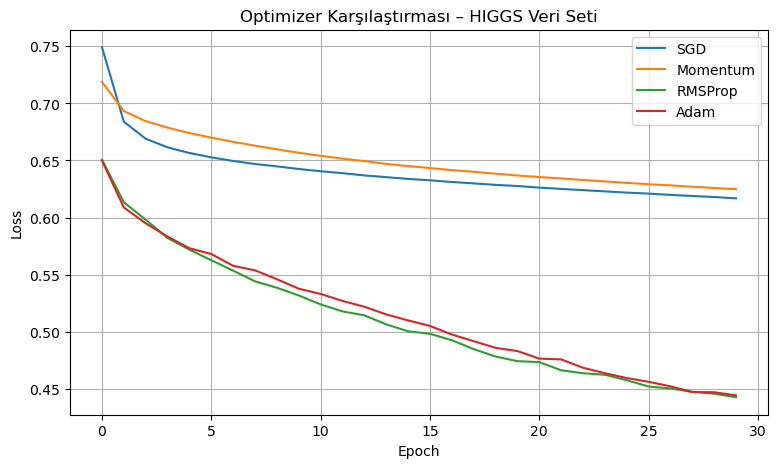

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(loss_sgd, label="SGD")
plt.plot(loss_momentum, label="Momentum")
plt.plot(loss_rmsprop, label="RMSProp")
plt.plot(loss_adam, label="Adam")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Optimizer Karşılaştırması – HIGGS Veri Seti")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
lrs = [0.1, 0.01, 0.001]
lr_losses = {}

epochs = 20
arch = [28, 64, 32, 1]

for lr in lrs:
    mlp = MLP(arch, activation="relu")
    losses = train_mlp(
        model=mlp,
        X=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=64,
        lr=lr,
        optimizer="adam"
    )
    lr_losses[lr] = losses


Epoch 1/20 - Loss: 0.6971
Epoch 2/20 - Loss: 0.6920
Epoch 3/20 - Loss: 0.6938
Epoch 4/20 - Loss: 0.6933
Epoch 5/20 - Loss: 0.6933
Epoch 6/20 - Loss: 0.6933
Epoch 7/20 - Loss: 0.6938
Epoch 8/20 - Loss: 0.6936
Epoch 9/20 - Loss: 0.6929
Epoch 10/20 - Loss: 0.6928
Epoch 11/20 - Loss: 0.6933
Epoch 12/20 - Loss: 0.6933
Epoch 13/20 - Loss: 0.6937
Epoch 14/20 - Loss: 0.6930
Epoch 15/20 - Loss: 0.6931
Epoch 16/20 - Loss: 0.6942
Epoch 17/20 - Loss: 0.6926
Epoch 18/20 - Loss: 0.6930
Epoch 19/20 - Loss: 0.6927
Epoch 20/20 - Loss: 0.6942
Epoch 1/20 - Loss: 0.6502
Epoch 2/20 - Loss: 0.6133
Epoch 3/20 - Loss: 0.5955
Epoch 4/20 - Loss: 0.5845
Epoch 5/20 - Loss: 0.5762
Epoch 6/20 - Loss: 0.5662
Epoch 7/20 - Loss: 0.5614
Epoch 8/20 - Loss: 0.5539
Epoch 9/20 - Loss: 0.5448
Epoch 10/20 - Loss: 0.5393
Epoch 11/20 - Loss: 0.5341
Epoch 12/20 - Loss: 0.5260
Epoch 13/20 - Loss: 0.5226
Epoch 14/20 - Loss: 0.5147
Epoch 15/20 - Loss: 0.5084
Epoch 16/20 - Loss: 0.5030
Epoch 17/20 - Loss: 0.4990
Epoch 18/20 - Loss:

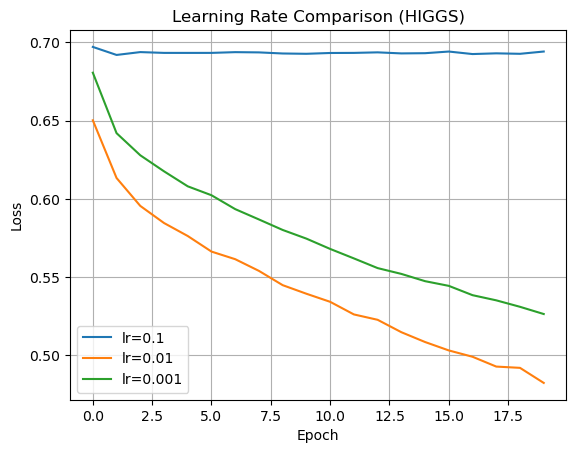

In [16]:
for lr, losses in lr_losses.items():
    plt.plot(losses, label=f"lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Rate Comparison (HIGGS)")
plt.legend()
plt.grid(True)
plt.show()



In [17]:
activations = ["relu", "sigmoid"]
act_losses = {}

for act in activations:
    mlp = MLP([28, 64, 32, 1], activation=act)
    losses = train_mlp(
        model=mlp,
        X=X_train,
        y=y_train,
        epochs=20,
        batch_size=64,
        lr=0.01,
        optimizer="adam"
    )
    act_losses[act] = losses


Epoch 1/20 - Loss: 0.6506
Epoch 2/20 - Loss: 0.6132
Epoch 3/20 - Loss: 0.5985
Epoch 4/20 - Loss: 0.5838
Epoch 5/20 - Loss: 0.5731
Epoch 6/20 - Loss: 0.5668
Epoch 7/20 - Loss: 0.5583
Epoch 8/20 - Loss: 0.5495
Epoch 9/20 - Loss: 0.5451
Epoch 10/20 - Loss: 0.5398
Epoch 11/20 - Loss: 0.5325
Epoch 12/20 - Loss: 0.5242
Epoch 13/20 - Loss: 0.5173
Epoch 14/20 - Loss: 0.5129
Epoch 15/20 - Loss: 0.5070
Epoch 16/20 - Loss: 0.5009
Epoch 17/20 - Loss: 0.4986
Epoch 18/20 - Loss: 0.4883
Epoch 19/20 - Loss: 0.4851
Epoch 20/20 - Loss: 0.4824
Epoch 1/20 - Loss: 0.6591
Epoch 2/20 - Loss: 0.6343
Epoch 3/20 - Loss: 0.6159
Epoch 4/20 - Loss: 0.6006
Epoch 5/20 - Loss: 0.5861
Epoch 6/20 - Loss: 0.5753
Epoch 7/20 - Loss: 0.5672
Epoch 8/20 - Loss: 0.5603
Epoch 9/20 - Loss: 0.5507
Epoch 10/20 - Loss: 0.5436
Epoch 11/20 - Loss: 0.5383
Epoch 12/20 - Loss: 0.5302
Epoch 13/20 - Loss: 0.5241
Epoch 14/20 - Loss: 0.5175
Epoch 15/20 - Loss: 0.5092
Epoch 16/20 - Loss: 0.5056
Epoch 17/20 - Loss: 0.4975
Epoch 18/20 - Loss:

In [18]:
activations = ["relu", "sigmoid"]
activation_losses = {}

for act in activations:
    mlp = MLP([28, 64, 32, 1], activation=act)
    
    losses = train_mlp(
        model=mlp,
        X=X_train,
        y=y_train,
        epochs=20,
        batch_size=64,
        lr=0.01,
        optimizer="adam"
    )
    
    activation_losses[act] = losses


Epoch 1/20 - Loss: 0.6525
Epoch 2/20 - Loss: 0.6136
Epoch 3/20 - Loss: 0.5957
Epoch 4/20 - Loss: 0.5858
Epoch 5/20 - Loss: 0.5751
Epoch 6/20 - Loss: 0.5682
Epoch 7/20 - Loss: 0.5613
Epoch 8/20 - Loss: 0.5590
Epoch 9/20 - Loss: 0.5484
Epoch 10/20 - Loss: 0.5436
Epoch 11/20 - Loss: 0.5359
Epoch 12/20 - Loss: 0.5323
Epoch 13/20 - Loss: 0.5224
Epoch 14/20 - Loss: 0.5212
Epoch 15/20 - Loss: 0.5145
Epoch 16/20 - Loss: 0.5088
Epoch 17/20 - Loss: 0.5053
Epoch 18/20 - Loss: 0.4975
Epoch 19/20 - Loss: 0.4963
Epoch 20/20 - Loss: 0.4880
Epoch 1/20 - Loss: 0.6571
Epoch 2/20 - Loss: 0.6299
Epoch 3/20 - Loss: 0.6138
Epoch 4/20 - Loss: 0.5979
Epoch 5/20 - Loss: 0.5847
Epoch 6/20 - Loss: 0.5731
Epoch 7/20 - Loss: 0.5670
Epoch 8/20 - Loss: 0.5577
Epoch 9/20 - Loss: 0.5500
Epoch 10/20 - Loss: 0.5417
Epoch 11/20 - Loss: 0.5355
Epoch 12/20 - Loss: 0.5268
Epoch 13/20 - Loss: 0.5213
Epoch 14/20 - Loss: 0.5154
Epoch 15/20 - Loss: 0.5080
Epoch 16/20 - Loss: 0.5009
Epoch 17/20 - Loss: 0.4994
Epoch 18/20 - Loss:

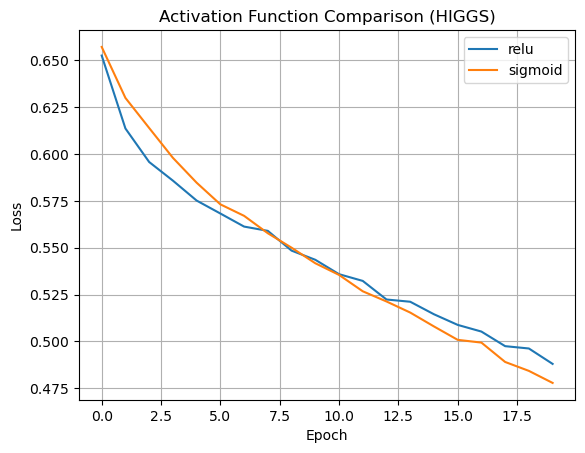

In [19]:
import matplotlib.pyplot as plt

for act, losses in activation_losses.items():
    plt.plot(losses, label=act)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Activation Function Comparison (HIGGS)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Test seti üzerinde tahmin
y_prob = mlp.forward(X_test)
y_pred = (y_prob > 0.5).astype(int)

print("HIGGS Test Accuracy:", accuracy_score(y_test, y_pred))
print("HIGGS Test F1-score:", f1_score(y_test, y_pred))
print("HIGGS Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


HIGGS Test Accuracy: 0.698
HIGGS Test F1-score: 0.7026095519448547
HIGGS Confusion Matrix:
[[1365  531]
 [ 677 1427]]


In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#sparse -> batch batch dense
def predict_mlp_sparse(model, X_sparse, batch_size=500):
    preds = []
    for i in range(0, X_sparse.shape[0], batch_size):
        X_batch = X_sparse[i:i+batch_size].toarray()
        preds.append(model.forward(X_batch))
    return np.vstack(preds)

y_prob_rcv1 = predict_mlp_sparse(mlp_rcv1_adam, X_test_rcv1, batch_size=500)
y_pred_rcv1 = (y_prob_rcv1 > 0.5).astype(int)

print("RCV1 Test Accuracy:", accuracy_score(y_test_rcv1, y_pred_rcv1))
print("RCV1 Test F1-score:", f1_score(y_test_rcv1, y_pred_rcv1))
print("RCV1 Confusion Matrix:")
print(confusion_matrix(y_test_rcv1, y_pred_rcv1))


RCV1 Test Accuracy: 0.9025
RCV1 Test F1-score: 0.8927982407916437
RCV1 Confusion Matrix:
[[993  89]
 [106 812]]
